In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import glob
import sys
import pandas as pd
import random
import numpy as np
import imageio
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import tensorflow
tensorflow.compat.v1.disable_eager_execution()

In [2]:
import astropy.units as u
import lightkurve as lk

In [3]:
def fold(lc, period, t0):
    t0_btjd = t0 - 2457000
    return lc.fold(period=period, epoch_time=t0_btjd)
class TESSPlanetTransit:
    def __init__(self, name, period=None, t0=None, lc = None):
        self.name = name
        self.period = period
        self.t0 = t0
        folded_lc = fold(lc, period, t0)
        self.time = folded_lc.time.value
        self.flux = folded_lc.flux.value

In [4]:
import pickle

with open("transits.pkl", "rb") as f:
    transits = pickle.load(f)

In [5]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random

I had to decrease the number of points in each transit becauses generating too much points seem to really stress the algorithm out (I'm getting losses of NaN...). Given that my data is phase-folded, I hope this doesn't change the general trend of the data too much.

In [6]:
SIZE = 512
def resample_phase_flux(phase, flux, target_len=SIZE):
    
    flux = np.array(flux)
    phase = np.array(phase)
    mask = ~np.isnan(phase) & ~np.isnan(flux)

    phase = phase[mask]
    flux = flux[mask]

    sort_idx = np.argsort(phase)
    phase = phase[sort_idx]
    flux = flux[sort_idx]

    phase_target = np.linspace(phase[0],phase[-1], target_len)

    flux_interp = np.interp(phase_target, phase, flux)
    
    
    flux_interp = (flux_interp - np.min(flux_interp)) / (np.max(flux_interp) - np.min(flux_interp))

    return np.stack([phase_target, flux_interp], axis=-1)

data = []
for i in range(len(transits)):
    data.append(resample_phase_flux(transits[i].time, transits[i].flux))

data = np.array(data)
data.shape

(538, 512, 2)

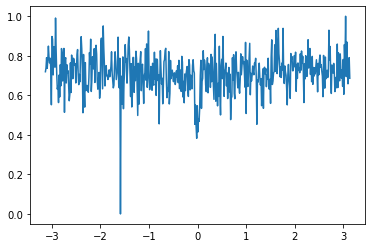

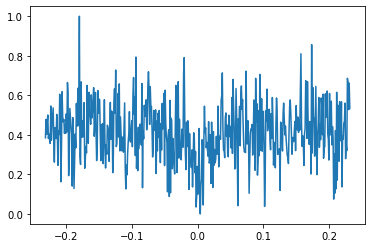

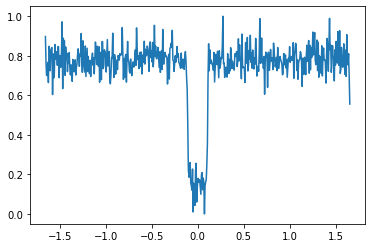

In [7]:
plt.plot(data[0][:,0], data[0][:,1])
plt.show()
plt.plot(data[1][:,0], data[1][:,1])
plt.show()
plt.plot(data[2][:,0], data[2][:,1])
plt.show()

In [8]:
LATENT_SPACE_SIZE = 16
input_data = tensorflow.keras.layers.Input(shape=(SIZE, 2))
encoded = tensorflow.keras.layers.Conv1D(32, kernel_size=5, activation='relu', padding='same')(input_data)
encoded = tensorflow.keras.layers.MaxPooling1D(pool_size=2)(encoded)

encoded = tensorflow.keras.layers.Conv1D(16, kernel_size=5, activation='relu', padding='same')(input_data)
encoded = tensorflow.keras.layers.MaxPooling1D(pool_size=2)(encoded)

encoded = tensorflow.keras.layers.Conv1D(8, kernel_size=5, activation='relu', padding='same')(input_data)
encoded = tensorflow.keras.layers.MaxPooling1D(pool_size=2)(encoded)

encoded = tensorflow.keras.layers.Flatten()(encoded)
encoded = tensorflow.keras.layers.Dense(32, activation='relu')(encoded)

distribution_mean = tensorflow.keras.layers.Dense(LATENT_SPACE_SIZE, name='variational_mean')(encoded)
distribution_variance = tensorflow.keras.layers.Dense(LATENT_SPACE_SIZE, name='variational_log_variance')(encoded)
latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])


encoder_model = tensorflow.keras.Model(input_data, latent_encoding)
encoder_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 2)]     0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 512, 8)       88          ['input_1[0][0]']                
                                                                                                  
 max_pooling1d_2 (MaxPooling1D)  (None, 256, 8)      0           ['conv1d_2[0][0]']               
                                                                                                  
 flatten (Flatten)              (None, 2048)         0           ['max_pooling1d_2[0][0]']        
                                                                                              

In [9]:
decoder_input = tensorflow.keras.layers.Input(shape=LATENT_SPACE_SIZE)
decoded = tensorflow.keras.layers.Dense(64*8, activation='relu')(decoder_input)
decoded = tensorflow.keras.layers.Reshape((64, 8))(decoded)
decoded = tensorflow.keras.layers.Conv1DTranspose(8, kernel_size=5, activation='relu', padding='same')(decoded)
decoded = tensorflow.keras.layers.UpSampling1D(2)(decoded)
decoded = tensorflow.keras.layers.Conv1DTranspose(16, kernel_size=5, activation='relu', padding='same')(decoded)
decoded = tensorflow.keras.layers.UpSampling1D(2)(decoded)
decoded = tensorflow.keras.layers.Conv1DTranspose(16, kernel_size=5, activation='relu', padding='same')(decoded)
decoded = tensorflow.keras.layers.UpSampling1D(2)(decoded)

decoder_output = tensorflow.keras.layers.Conv1DTranspose(2, kernel_size=5, activation='sigmoid', padding='same')(decoded)

# phase_out = tensorflow.keras.layers.Conv1DTranspose(1, kernel_size=5, activation='linear', padding='same')(decoded)
# flux_out = tensorflow.keras.layers.Conv1DTranspose(1, kernel_size=5, activation='sigmoid', padding='same')(decoded)
# decoder_output = tensorflow.keras.layers.Concatenate(axis=-1)([phase_out, flux_out])

decoder_model = tensorflow.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 512)               8704      
                                                                 
 reshape (Reshape)           (None, 64, 8)             0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 64, 8)            328       
 nspose)                                                         
                                                                 
 up_sampling1d (UpSampling1D  (None, 128, 8)           0         
 )                                                               
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 128, 16)          656 

In [10]:
encoded_train = encoder_model(input_data)
decoded_train = decoder_model(encoded_train)
autoencoder = tensorflow.keras.Model(input_data, decoded_train)

In [ ]:


def get_loss(distribution_mean, distribution_variance, factor, batch_size):

    def get_reconstruction_loss(y_true, y_pred, factor, batch_size):
        reconstruction_loss = tensorflow.math.squared_difference(
            y_true[:, :, 1],  # true flux
            y_pred[:, :, 1]   # predicted flux
        )
        reconstruction_loss_batch = tensorflow.reduce_sum(reconstruction_loss)/batch_size
        print_op = tensorflow.print("\nmse", 0.5*reconstruction_loss_batch*factor, output_stream="./test.txt")
        with tensorflow.control_dependencies([print_op]):
            res = 0.5*reconstruction_loss_batch*factor
        return res

    def get_kl_loss(distribution_mean, distribution_variance, batch_size):
        print_op = tensorflow.print("\nvariance", distribution_variance, output_stream="./test.txt")
        with tensorflow.control_dependencies([print_op]):
            distribution_variance = tensorflow.clip_by_value(distribution_variance, -10.0, 10.0)
        kl_loss = LATENT_SPACE_SIZE + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_sum(kl_loss)/batch_size
        print_op = tensorflow.print("\nkl", kl_loss_batch*(-0.5), output_stream="./test.txt")
        with tensorflow.control_dependencies([print_op]):
            res = kl_loss_batch*(-0.5)
        return res

    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred, factor, batch_size)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance, batch_size)
        return reconstruction_loss_batch + kl_loss_batch

    return total_loss

In [12]:
X_train, X_test = train_test_split(data, test_size=0.2)


In [13]:
batch_size = 64
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance, factor = 1.0,
                                  batch_size = batch_size), optimizer='adam')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 2)]          0         
                                                                 
 model (Functional)          (None, 16)                66712     
                                                                 
 model_1 (Functional)        (None, 512, 2)            11146     
                                                                 
Total params: 77,858
Trainable params: 77,858
Non-trainable params: 0
_________________________________________________________________


In [14]:
autoencoder.fit(X_train, X_train, epochs=50, batch_size=64, validation_data=(X_test, X_test))

Train on 430 samples, validate on 108 samples
Epoch 1/50
320/430 [=====================>........] - ETA: 0s - loss: 525.4493 

/Users/nina/anaconda3/envs/sds365/lib/python3.8/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


430/430 [==============================] - 2s 4ms/sample - loss: 390.2153 - val_loss: 1337.0223
Epoch 2/50
430/430 [==============================] - 1s 2ms/sample - loss: 405.3738 - val_loss: 996.4769
Epoch 3/50
430/430 [==============================] - 1s 1ms/sample - loss: 451.0235 - val_loss: 809.1832
Epoch 4/50
430/430 [==============================] - 0s 756us/sample - loss: 492.4393 - val_loss: 1004.7458
Epoch 5/50
430/430 [==============================] - 0s 611us/sample - loss: 337.4221 - val_loss: 623.2132
Epoch 6/50
430/430 [==============================] - 0s 338us/sample - loss: 328.1420 - val_loss: 674.2091
Epoch 7/50
430/430 [==============================] - 0s 301us/sample - loss: 461.0814 - val_loss: 606.9882
Epoch 8/50
430/430 [==============================] - 0s 265us/sample - loss: 489.9899 - val_loss: 1546.8340
Epoch 9/50
430/430 [==============================] - 0s 302us/sample - loss: 815.3283 - val_loss: 805.1034
Epoch 10/50
430/430 [=====================

In [15]:
autoencoder.save("My_Trained_VAE")
encoder_model.save("My_Trained_encoder")
decoder_model.save("My_Trained_decoder")

INFO:tensorflow:Assets written to: My_Trained_VAE/assets


INFO:tensorflow:Assets written to: My_Trained_VAE/assets


INFO:tensorflow:Assets written to: My_Trained_encoder/assets


INFO:tensorflow:Assets written to: My_Trained_encoder/assets


INFO:tensorflow:Assets written to: My_Trained_decoder/assets


INFO:tensorflow:Assets written to: My_Trained_decoder/assets


The reconstructed curve is quite smoothed out. I think this is just what VAE does? When I did this on photos, the reconstructed photos also became super blurry.

Text(0.5, 1.0, 'Reconstructed')

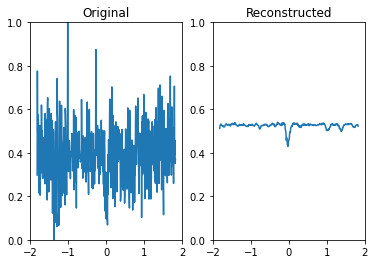

In [23]:
one_sample = X_test[1]
fig, axs = plt.subplots(1, 2)
axs[0].plot(one_sample[:,0], one_sample[:,1])
axs[0].set_ylim(0,1)
axs[0].set_title("Original")
reconstructed = autoencoder.predict(one_sample.reshape(1, SIZE, 2))[0]
axs[1].plot(one_sample[:,0], reconstructed[:,1])
axs[1].set_ylim(0,1)
axs[1].set_title("Reconstructed")


Here's just a zoomed in plot of the reconstructed to see there are some fluctuations.

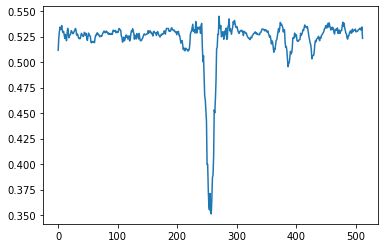

In [17]:
plt.plot(reconstructed[:,1])

This function generates fake transits by moving in latent space randomly.

In [18]:
def GenerateTransits(data, LATENT_SPACE_SIZE, noise_level):
    sample_index = random.sample(range(1, len(data)), 15)
    latent_space = noise_level*np.random.normal(size=(15,LATENT_SPACE_SIZE))+encoder_model.predict(data[sample_index])
    generated_transit = decoder_model.predict(latent_space)
    fig = plt.figure(figsize=(15,10))
    number_of_images = len(generated_transit)
    for i in range(number_of_images):
        ax = fig.add_subplot(3, 5, i+1)
        ax.plot(generated_transit[i][:,1])

We can generate fake transits now! Here I generate 15 fake transits at a time. I've plotted a few different noise levels.

/Users/nina/anaconda3/envs/sds365/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


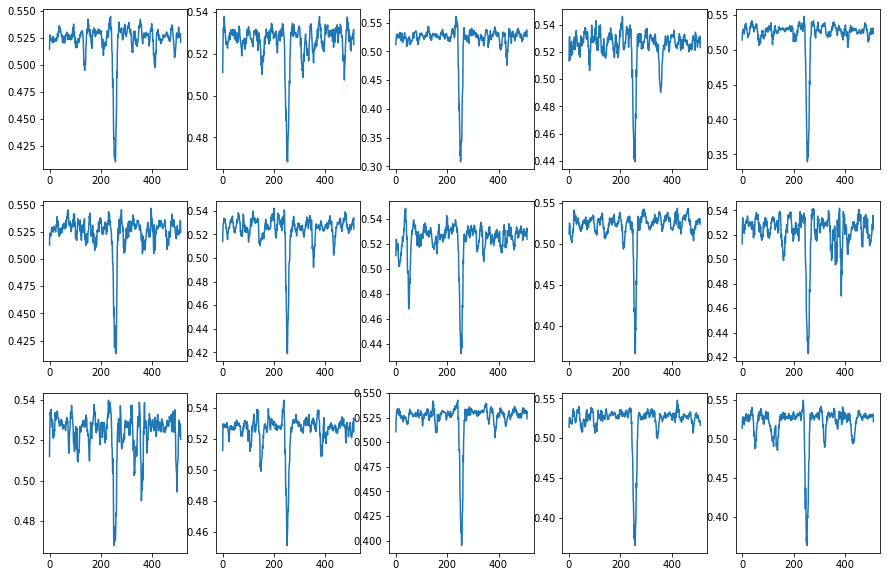

In [19]:
GenerateTransits(data, LATENT_SPACE_SIZE, 0.5)

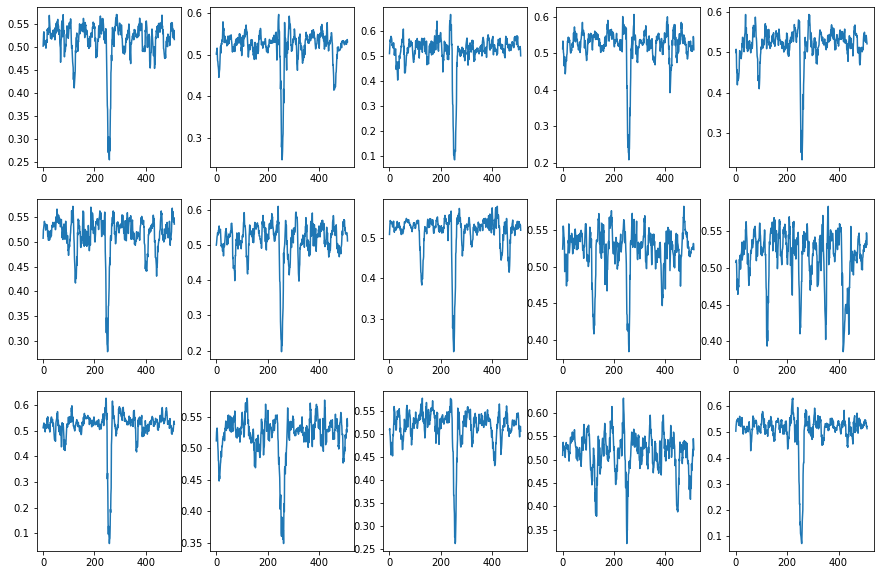

In [39]:
GenerateTransits(data, LATENT_SPACE_SIZE, 5)

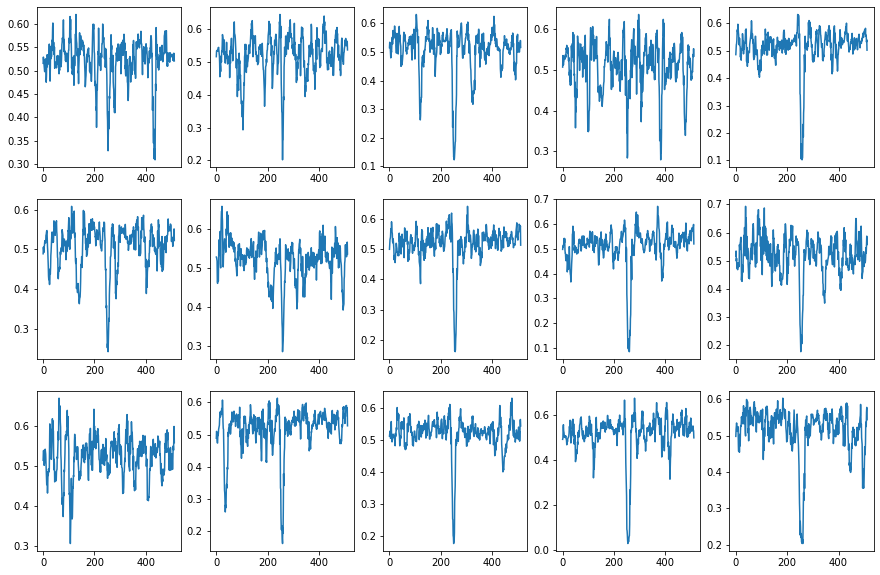

In [38]:
GenerateTransits(data, LATENT_SPACE_SIZE, 8)

I would say at the noise level at 5 or 8, they do sort of resemble noisy TESS data. The major problems I'm seeing are 1. the dips are too pointy (perhaps denser sampling would improve this) 2. we sometimes get multiple dips, there is probably somewhere in the latent space that prefers multiple dips, this is perhaps not good, as this is phase folded.

This also works not in the same way I imagined it would. I thought the reconstructed would match the noise and shape of the TESS data really well, and then adding noise level (moving further in latent space from the traning data) just makes weird shapes. But it turns out only by turning up the noise level can we immitate the TESS transits well. And the main goal of this is to provide data augementation for transit detection algorithms, so immitating TESS is the main objective. I'm working with a "if it looks like a duck, swims like a duck, and quacks like a duck, then it probably is a duck" rule here. So I'm going to say this works despite me not expecting it to work this way.

Furture directions are
1. I still don't think it was the best idea to phase fold the light curves. After all, shouldn't transit detection algorithms rely on periodically appearing dips instead of just 1 dip?
2. I think I should not be lazy and revist why downloading all the transit data gave me an error (perhaps just time out). Using just 1 sector for each planet is not a lot of samples
3. When I proposed this I promised to do conditional VAE and generate transits on planet properties and stellar properties. I'll try that and see how it goes... I'm not very optimistic though